# Simulate policies and claims with "auto-like characteristics", model-fit, predict a loss ratio

In [1]:
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import yellowbrick as yb

In [2]:
import pandas_profiling

/home/ian/anaconda3/envs/generative_insurance_model/lib/python3.6/site-packages/pandas_profiling/base.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/ian/anaconda3/envs/generative_insurance_model/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ian/anaconda3/envs/generative_insurance_model/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ian/anaconda3/envs/generative_insurance_model/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ian/anaconda3/envs/generative_insurance_model/lib/python3.6/site-packages/traitlets/config/application.py", 

In [3]:
%load_ext watermark
%watermark -d -m -v -p numpy,matplotlib,sklearn,eli5,statsmodels,seaborn,yellowbrick -g

2017-12-06 

CPython 3.6.3
IPython 6.2.1

numpy 1.13.3
matplotlib 2.1.0
sklearn 0.19.1
eli5 0.8
statsmodels 0.8.0
seaborn 0.8.1
yellowbrick 0.5

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.9.66-040966-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : 64f8ae579183426ea5fa4c416c772223808f4943


# Outline

* Make a single variable - years experience negative relt to prob of accident
* Generate noise
* Simulate some people
* Do 100 journeys and simulate accidents
* For accidents model their size
* Plot some graphs
* Can I build a frequency model?
  * yellowbrick on the regressed predictions

In [4]:
NBR_JOURNEYS = 20
NBR_PEOPLE = 10_000

RANDOM_STATE = 0 # fixed random seed for reproducibility

In [5]:
def model_years_experience(years_experience):
    #prob_accident_years_experience = (years_experience * -0.002) + 0.02 # rare accidents
    prob_accident_years_experience = (years_experience * -0.01) + 0.1 # common accidents
    #prob_accident_years_experience = (years_experience * -0.002) + 0.05 # uncommon accidents
    prob_accident_years_experience += np.random.normal(scale=0.01, size=years_experience.shape[0])
    prob_accident_years_experience = np.maximum(prob_accident_years_experience, 0.005)
    return prob_accident_years_experience

years_experience = np.random.uniform(low=0, high=10, size=NBR_PEOPLE).astype(np.int_)
prob_accident_years_experience = model_years_experience(years_experience)

df_people = pd.DataFrame({'years_experience': years_experience, 
              'prob_accident_years_experience': prob_accident_years_experience})

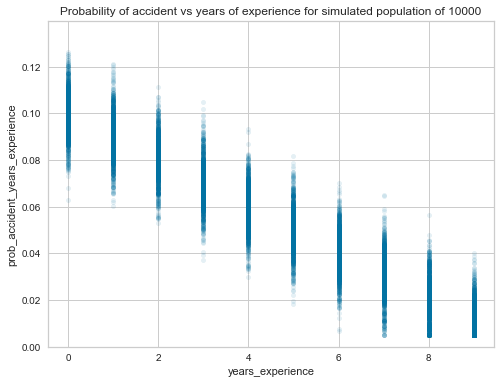

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
df_people.plot(kind="scatter", x='years_experience', y='prob_accident_years_experience', ax=ax, alpha=0.1);
ax.set(ylim=0)
ax.set_title(f"Probability of accident vs years of experience for simulated population of {NBR_PEOPLE}");

In [7]:
df_people.head()

,prob_accident_years_experience,years_experience
0,0.021325,9
1,0.099806,1
2,0.101454,0
3,0.077747,0
4,0.030038,7


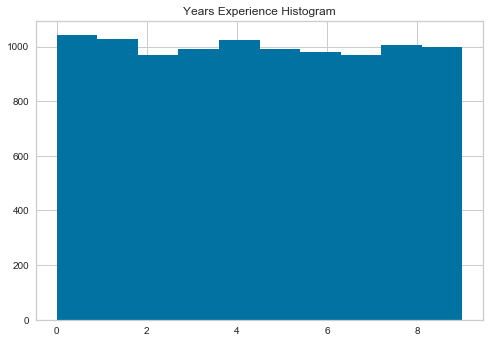

In [8]:
fig, ax = plt.subplots()
df_people.years_experience.hist(bins=10, ax=ax)
ax.set_title("Years Experience Histogram");

## Model some accidents

In [9]:
nbr_claims = np.zeros(shape=NBR_PEOPLE).astype(np.int_)
for journey in range(NBR_JOURNEYS):
    coin_flips = np.random.uniform(size=NBR_PEOPLE)
    nbr_claims += (coin_flips < prob_accident_years_experience)

## Model claims

In [10]:
df_people['nbr_claims'] = nbr_claims
df_people.head()

,prob_accident_years_experience,years_experience,nbr_claims
0,0.021325,9,1
1,0.099806,1,1
2,0.101454,0,1
3,0.077747,0,1
4,0.030038,7,0


### Experiment with various configurations

* small and large Gaussian losses
* Gamma losses
* Logic switch to do things like halve level of a loss if you're experienced, some of the time

In [11]:
from numpy.random import gamma

def model_accident(years_experience):
    """Sample different types of accident"""
    nbr = np.random.uniform()
    #if nbr < 0.9: # some large accidents
    
    if nbr < 1.0: # always small accidents
        incurred = np.random.normal(loc=2000, scale=700)
        kind = "small"
    #else:
    #    incurred = np.random.normal(loc=10000, scale=5000)
    #    kind = "large"
    
    #incurred = gamma(5, 1, 1) * 100
    #incurred = gamma(2, 2, 1) * 100
    #kind = "gamma"
    
    # if 'experienced' then maybe cut the incurred
    # due to better experience
    #if years_experience >= 5:
    #    if np.random.uniform() < 0.5:
    #        incurred = incurred * 0.2
    
    # we need to cap above 0, 0 becomes the nil-claim from our real data
    incurred = max(incurred, 0)
    return incurred, kind

df_claims = pd.DataFrame()
for row_idx in range(df_people.shape[0]):
    claims = df_people.nbr_claims.iloc[row_idx]
    person = row_idx
    for claim_nbr in range(claims):
        incurred, kind = model_accident(df_people.iloc[row_idx].years_experience)        
        df_claims_tmp = pd.DataFrame({'incurred': incurred, 'kind': kind, 'person': person}, index=[df_claims.shape[0]])
        df_claims = df_claims.append(df_claims_tmp)
        
df_claims.head()

,incurred,kind,person
0,1733.195145,small,0
1,2578.587745,small,1
2,1670.362398,small,2
3,2188.973121,small,3
4,2948.453189,small,9


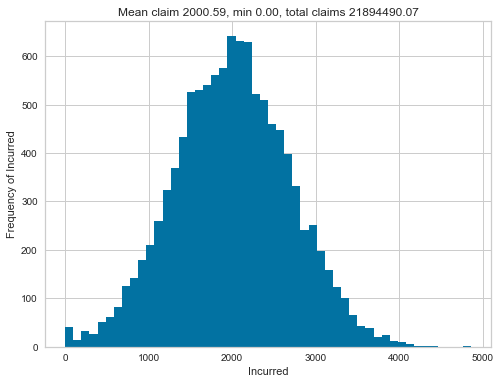

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
df_claims.incurred.hist(bins=50, ax=ax);
mean_claim = df_claims.incurred.mean()
total_claims = df_claims.incurred.sum()
min_claims = df_claims.incurred.min()
ax.set(ylabel="Frequency of Incurred", 
       xlabel="Incurred", 
       title=f"Mean claim {mean_claim:0.2f}, min {min_claims:0.2f}, total claims {total_claims:0.2f}");

## Count the frequencies of claim frequencies

In [13]:
claims_frequency_per_insured_with_claim = df_claims.groupby('person')['incurred'].count()
claims_frequency_per_insured_with_claim.head()

person
0    1
1    1
2    1
3    1
9    1
Name: incurred, dtype: int64

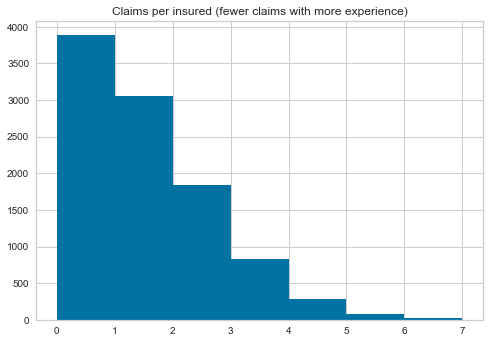

In [14]:
fig, ax = plt.subplots()
df_people.nbr_claims.hist(ax=ax, bins=np.arange(df_people.nbr_claims.max()+1));
ax.set(title="Claims per insured (fewer claims with more experience)");

In [15]:
df_people.head()

,prob_accident_years_experience,years_experience,nbr_claims
0,0.021325,9,1
1,0.099806,1,1
2,0.101454,0,1
3,0.077747,0,1
4,0.030038,7,0


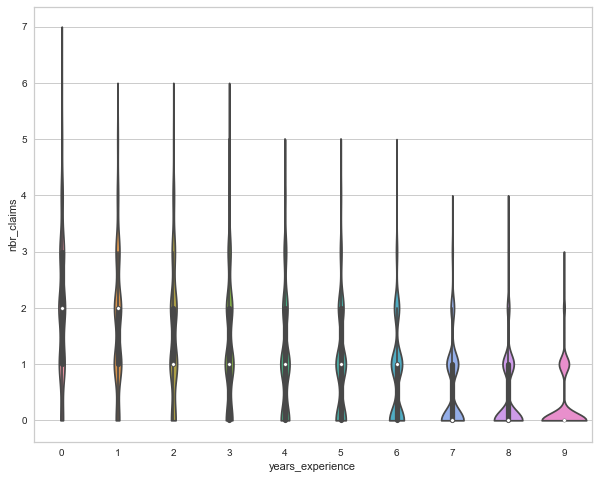

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))

#sns.stripplot(data=df_people, x="years_experience", y="nbr_claims", jitter=0.2);
#sns.boxplot(data=df_people, x="years_experience", y="nbr_claims");

sns.violinplot(data=df_people, x="years_experience", y="nbr_claims", jitter=0.2, ax=ax, cut=0);

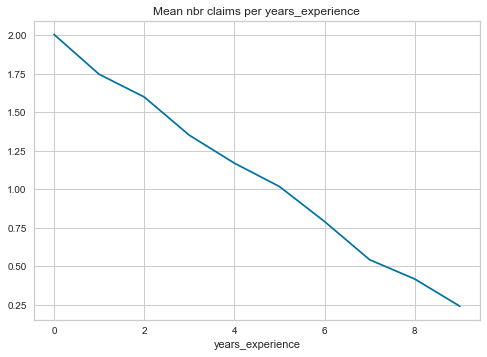

In [17]:
df_people.groupby(['years_experience'])['nbr_claims'].mean().plot().set_title("Mean nbr claims per years_experience");

In [18]:
df_claims.head()

,incurred,kind,person
0,1733.195145,small,0
1,2578.587745,small,1
2,1670.362398,small,2
3,2188.973121,small,3
4,2948.453189,small,9


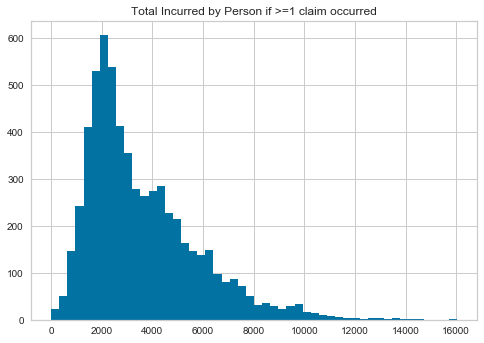

In [19]:
fig, ax = plt.subplots()
person_total_incurred = df_claims.groupby("person")['incurred'].sum()
person_total_incurred.hist(ax=ax, bins=50);
ax.set(title="Total Incurred by Person if >=1 claim occurred");

## Try pandas-profiling

In [20]:
#pandas_profiling.ProfileReport(df_people)

In [21]:
#pandas_profiling.ProfileReport(df_claims)

## Calculate a basic technical premium assuming all drivers are homogenous

In [22]:
mean_claim_per_insured = total_claims / df_people.shape[0]
print("Mean claim made per insured individual:", mean_claim_per_insured)

Mean claim made per insured individual: 2189.44900735


## Apply a loss ratio

In [23]:
df_policy_summary = df_people[['nbr_claims']].copy()
df_policy_summary['Premium'] = mean_claim_per_insured
df_policy_summary['TotalIncurred'] = df_claims.groupby("person")['incurred'].sum()
df_policy_summary['TotalIncurred'] = df_policy_summary['TotalIncurred'].fillna(0)
df_policy_summary['years_experience'] = df_people.years_experience
df_people.years_experience
df_policy_summary.head()

,nbr_claims,Premium,TotalIncurred,years_experience
0,1,2189.449007,1733.195145,9
1,1,2189.449007,2578.587745,1
2,1,2189.449007,1670.362398,0
3,1,2189.449007,2188.973121,0
4,0,2189.449007,0.000000,7


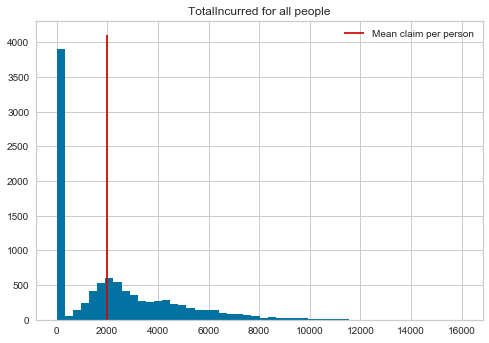

In [24]:
fig, ax = plt.subplots()
person_total_incurred = df_policy_summary['TotalIncurred'].hist(ax=ax, bins=50)
ax.set(title="TotalIncurred for all people");
ax.vlines(x=mean_claim, ymin=0, ymax=ax.get_ylim()[1], color='r', label="Mean claim per person");
ax.legend();

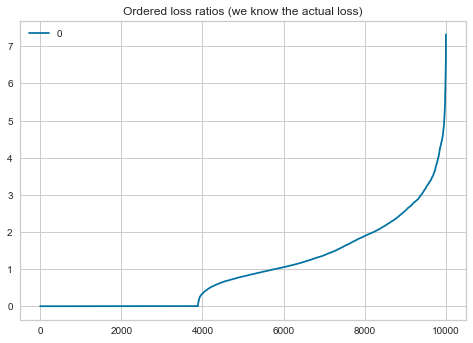

In [25]:
#loss_ratios = 1 / df_policy_summary.Premium * df_policy_summary.TotalIncurred
loss_ratios = df_policy_summary.TotalIncurred / df_policy_summary.Premium
fig, ax = plt.subplots()
loss_ratios.sort_values().reset_index().drop('index', axis=1).plot(ax=ax);
ax.set(title="Ordered loss ratios (we know the actual loss)"); 

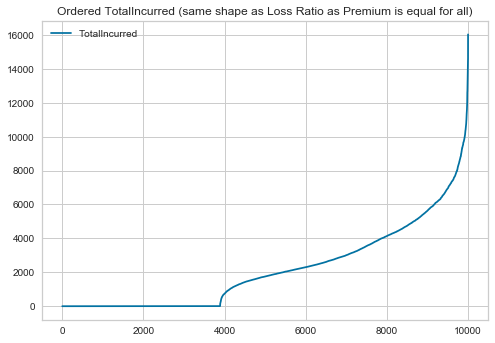

In [26]:
#loss_ratios = 1 / df_policy_summary.Premium * df_policy_summary.TotalIncurred
#loss_ratios = 
fig, ax = plt.subplots()
df_policy_summary.TotalIncurred.sort_values().reset_index().drop('index', axis=1).plot(ax=ax);
ax.set(title="Ordered TotalIncurred (same shape as Loss Ratio as Premium is equal for all)"); 

# EDA on Premium

## Claims vs Total Incurred

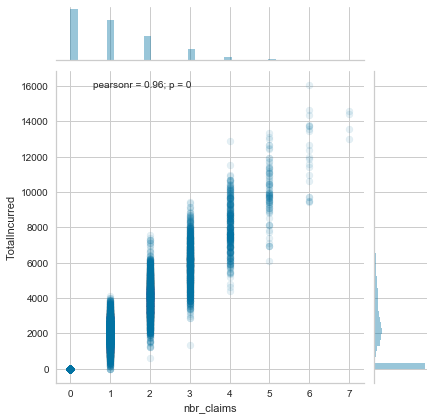

In [27]:
sns.jointplot(data=df_policy_summary, x='nbr_claims', y='TotalIncurred', alpha=0.1);

## Years experience vs number of claims

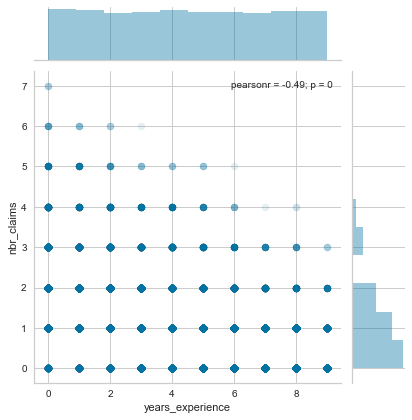

In [28]:
sns.jointplot(data=df_policy_summary, x='years_experience', y='nbr_claims', 
              alpha=0.1, 
              marginal_kws=dict(bins=10));

## Years experience vs Total Incurred


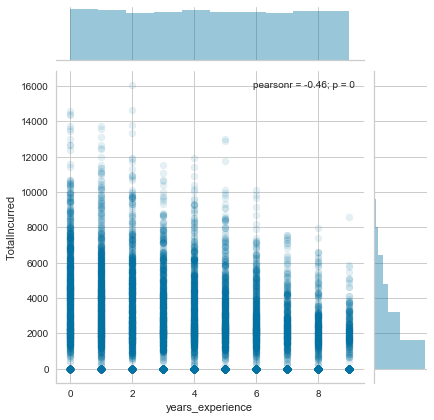

In [29]:
sns.jointplot(data=df_policy_summary, x='years_experience', y='TotalIncurred', alpha=0.1,
              marginal_kws=dict(bins=10));

# Predict TotalIncurred given a Casualty model

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

In [31]:
def plot_gains_curve(X_test, y_test, est):
    # predicted test losses
    fig, ax = plt.subplots()
    # calculate a null model - assumes test data is randomly shuffled (i.e. no ordering)
    random_case_cumsum = pd.Series(y_test.values).cumsum()
    random_case_cumsum.plot(ax=ax, label="null model"); 

    ideal_case_cumsum = pd.Series(pd.Series(y_test.values).sort_values(ascending=False).values).cumsum()
    ideal_case_cumsum.plot(ax=ax, label="ideal case");

    y_predict = est.predict(X_test)
    sorted_idx_y_predict = np.argsort(y_predict)[::-1]
    predicted_losses_sorted = y_predict[sorted_idx_y_predict]
    actual_losses_sorted = y_test.values[sorted_idx_y_predict]
    actual_losses_sorted_cumsum = pd.Series(actual_losses_sorted).cumsum()
    label = "model"
    label += ", 5% 95% quantiles {}".format(pd.Series(y_predict).quantile([0.05, 0.95]).values)
    actual_losses_sorted_cumsum.plot(ax=ax, label=label);
    
    area_between_prediction_random_cases = (actual_losses_sorted_cumsum.values - random_case_cumsum.values).sum()
    ax.set_title("Area between model and null case: {:,}".format(area_between_prediction_random_cases))
    ax.legend();

In [32]:
df_X_casualty = df_policy_summary[['years_experience']]
df_y_casualty = df_policy_summary['TotalIncurred'] > 0
print(df_y_casualty.shape)
X_train_casualty, X_test_casualty, y_train_casualty, y_test_casualty = train_test_split(df_X_casualty, df_y_casualty, random_state=RANDOM_STATE)

(10000,)


In [33]:
est = LogisticRegression()
est.fit(X_train_casualty, y_train_casualty)
print(est)
est.score(X_test_casualty, y_test_casualty)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


0.71360000000000001

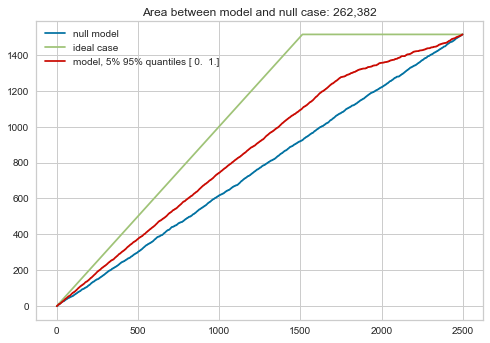

In [34]:
plot_gains_curve(X_test_casualty, y_test_casualty, est)

### Trial to order TotalIncurred by Casualty

In [35]:
df_X_total_incurred = df_policy_summary[['years_experience']]
df_y_total_incurred = df_policy_summary['TotalIncurred']
print(df_y_total_incurred.shape)
X_train_total_incurred, X_test_total_incurred, y_train_total_incurred, y_test_total_incurred = train_test_split(df_X_total_incurred, df_y_total_incurred, random_state=RANDOM_STATE)

(10000,)


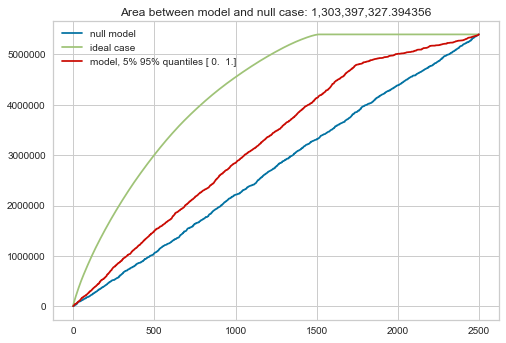

In [36]:
plot_gains_curve(X_test_casualty, y_test_total_incurred, est)

# Predict TotalIncurred given Years Experience with Regressor

In [37]:
df_X_total_incurred = df_policy_summary[['years_experience']]
df_y_total_incurred = df_policy_summary['TotalIncurred']
print(df_y_total_incurred.shape)
X_train_total_incurred, X_test_total_incurred, y_train_total_incurred, y_test_total_incurred = train_test_split(df_X_total_incurred, df_y_total_incurred, random_state=RANDOM_STATE)

(10000,)


In [38]:
from functools import partial
model = partial(RandomForestRegressor, max_depth=2, n_estimators=100)
#model = LinearRegression

#est = model(max_depth=1, n_estimators=10)
est = model()
est.fit(X_train_total_incurred, y_train_total_incurred)
print(est)
est.score(X_test_total_incurred, y_test_total_incurred)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


0.20258229495624891

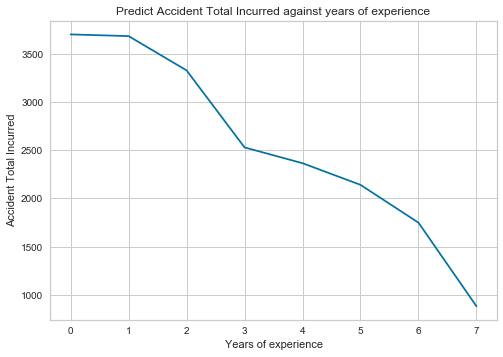

In [39]:
def plot_predictions_against_years_experience(est, ylabel="undef"):
    fig, ax = plt.subplots()
    pd.Series(est.predict([[0], [1], [2], [3], [4], [5], [6], [7]])).plot(ax=ax);
    ax.set(title="Predict {} against years of experience".format(ylabel),
           xlabel="Years of experience",
           ylabel=ylabel);
    
plot_predictions_against_years_experience(est, ylabel="Accident Total Incurred")

### Build a gains curve

Rank all predicts in order of largest to smallest predicted claim, plot in order using cumulative incurred, after do a cumulative plot

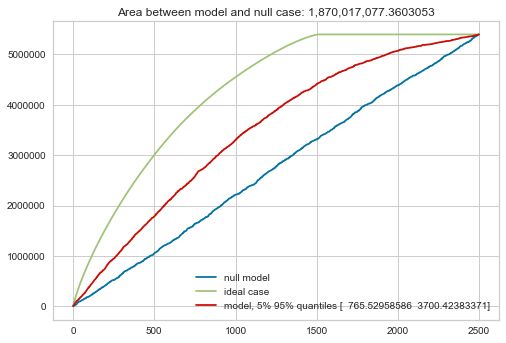

In [40]:
plot_gains_curve(X_test_total_incurred, y_test_total_incurred, est)

# Predict TotalIncurred given Years Experience with Frequency Severity Model

## Frequency model

In [41]:
df_X_freq = df_policy_summary[['years_experience']]
df_y_freq = df_policy_summary['nbr_claims']
print(df_y_freq.shape)
X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(df_X_freq, df_y_freq, random_state=RANDOM_STATE)

(10000,)


In [42]:
est_freq = model()
est_freq.fit(X_train_freq, y_train_freq)
print(est_freq)
est_freq.score(X_test_freq, y_test_freq)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


0.22557137553192277

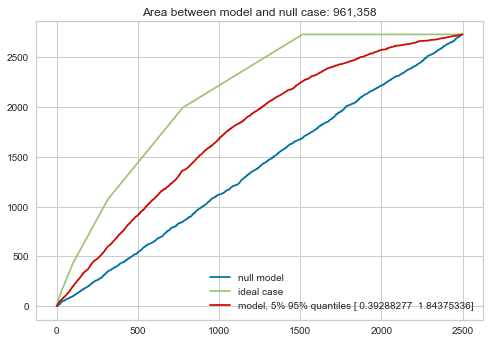

In [43]:
plot_gains_curve(X_test_freq, y_test_freq, est_freq)

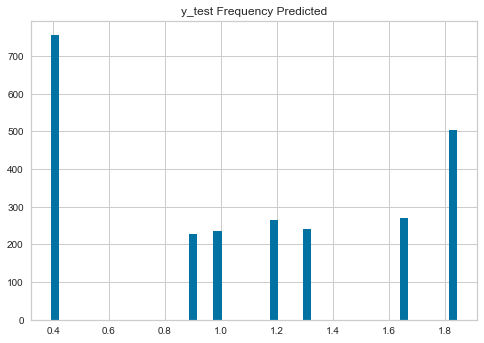

In [44]:
y_test_freq_predicted = est_freq.predict(X_test_freq)
pd.Series(y_test_freq_predicted).hist(bins=50).set(title="y_test Frequency Predicted");

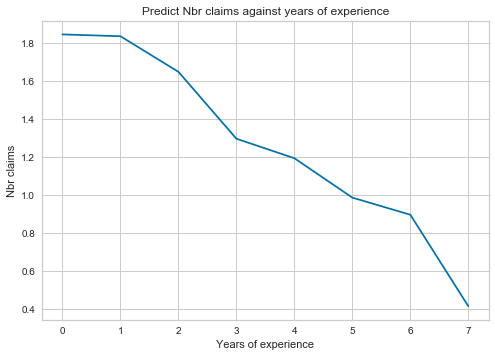

In [45]:
plot_predictions_against_years_experience(est_freq, ylabel="Nbr claims")

## Severity model if claims were made (claims >0 only)

Get all claim events from `df_claims`, join with `years_experience`, train and test

In [46]:
df_claims.head()

,incurred,kind,person
0,1733.195145,small,0
1,2578.587745,small,1
2,1670.362398,small,2
3,2188.973121,small,3
4,2948.453189,small,9


In [47]:
df_severity = df_claims.set_index('person').join(df_people['years_experience']).query("incurred>0")
print(df_claims.shape, df_people.shape)
print(df_severity.shape)
assert df_severity.query("incurred==0").count().all() == 0

df_severity.head()

(10944, 3) (10000, 3)
(10915, 3)


,incurred,kind,years_experience
0,1733.195145,small,9
1,2578.587745,small,1
2,1670.362398,small,0
3,2188.973121,small,0
9,2948.453189,small,0


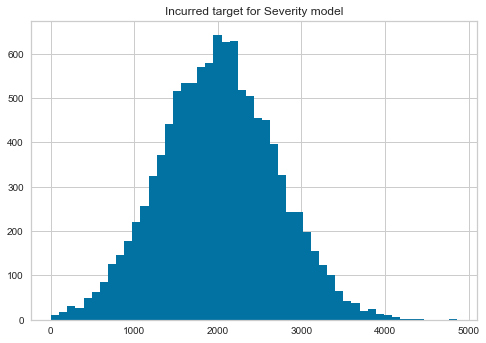

In [48]:
df_severity.incurred.hist(bins=50).set(title="Incurred target for Severity model");

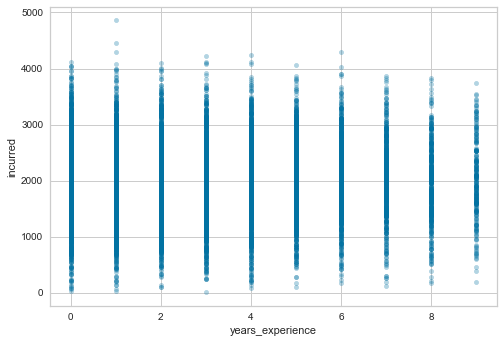

In [49]:
df_severity.plot(kind="scatter", x='years_experience', y='incurred', alpha=0.3);

In [50]:
df_X_sev = df_severity[['years_experience']]
df_y_sev = df_severity['incurred']
X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(df_X_sev, df_y_sev, random_state=RANDOM_STATE)

est_sev = model()
est_sev.fit(X_train_sev, y_train_sev)
print(est_sev)
est_sev.score(X_test_sev, y_test_sev)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


0.00035921531601257328

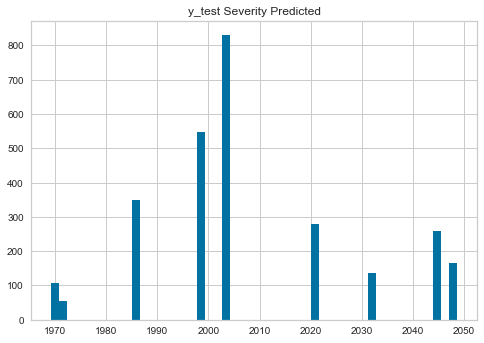

In [51]:
y_test_sev_predicted = est_sev.predict(X_test_sev);
pd.Series(y_test_sev_predicted).hist(bins=50).set(title="y_test Severity Predicted");

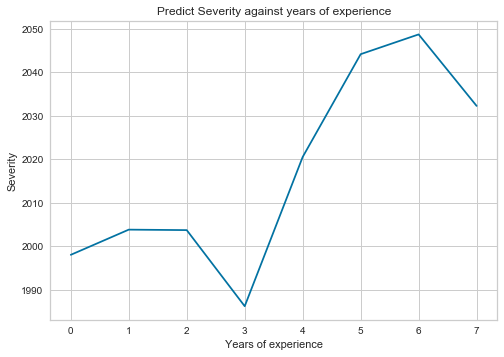

In [52]:
plot_predictions_against_years_experience(est_sev, ylabel="Severity")

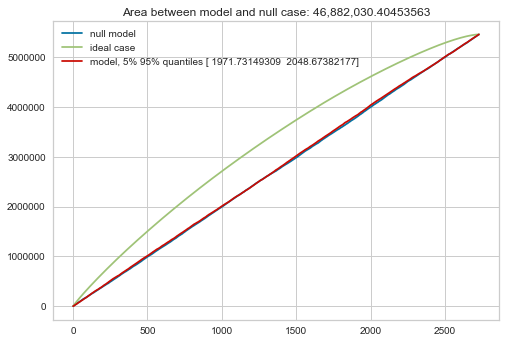

In [53]:
plot_gains_curve(X_test_sev, y_test_sev, est_sev)

## Combine Frequency and Severity models

In [54]:
sev_predict = est_sev.predict(X_train_total_incurred)
freq_predict = est_freq.predict(X_train_total_incurred)
sev_predict.shape, freq_predict.shape

((7500,), (7500,))

In [55]:
class SeverityFrequencyEstimator:
    def __init__(self, est_sev, est_freq):
        self.est_sev = est_sev
        self.est_freq = est_freq        
        
    def predict(self, X):
        sev_predict = self.est_sev.predict(X)
        freq_predict = self.est_freq.predict(X)
        return sev_predict * freq_predict
    
est_sev_freq = SeverityFrequencyEstimator(est_sev, est_freq)
est_sev_freq.predict(X_train_total_incurred).shape

(7500,)

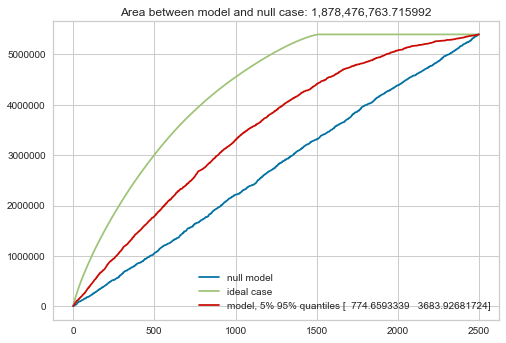

In [56]:
plot_gains_curve(X_test_total_incurred, y_test_total_incurred, est_sev_freq)

# Sanity checks on data

In [57]:
assert (X_train_casualty.index == X_train_total_incurred.index).all()
assert (X_train_casualty.index == X_train_freq.index).all()
# note cannot test X_train_sev as severity is only developed for >0 claim rows

In [58]:
print("Notebook finished running on ", datetime.datetime.now())

Notebook finished running on  2017-12-06 15:32:37.121779
